In [1]:
#best fitting results 
setwd("/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/data/")

In [3]:
getwd()

[1] "/lustre1/project/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/data"

In [5]:
library(data.table)
library(magrittr)

In [22]:
p.threshold <- c(0.00000005,0.00001,0.0001,0.2,0.3,0.4,0.5)
#OK

In [23]:
p.threshold

[1] 0.001 0.050 0.100 0.200 0.300 0.400 0.500

In [64]:
phenotype <- fread("/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/data/final_phenotypes.txt")
#OK

In [25]:
head(phenotype)

IID,IID,IBDvsCON
<int>,<int>,<int>
9263,9263,1
9535,9535,2
5924,5924,2
2762,2762,2
9323,9323,1
7670,7670,2


In [26]:
colnames(phenotype) <- c('FID','IID','IBDvsCON')
#OK
head(phenotype)

FID,IID,IBDvsCON
<int>,<int>,<int>
9263,9263,1
9535,9535,2
5924,5924,2
2762,2762,2
9323,9323,1
7670,7670,2


In [65]:
pcs <- fread("/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/data/real_soniya_final_IBP.eigenvec", header=F) %>%
    setnames(., colnames(.), c("FID", "IID", paste0("PC",1:6)) )
# The first command reads in the dataset, the command "header=F" specifies 
# that there are no column names associated with the dataset.

# The default output from plink does not include a header
# To make things simple, we will add the appropriate headers
# (1:6 because there are 6 PCs)

#OK
head(pcs)

FID,IID,PC1,PC2,PC3,PC4,PC5,PC6
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9263,9263,-0.00145430,-0.000247532,-0.000917923,-6.73271e-05,-0.000080967,-0.00177707
9535,9535,-0.00105226,-0.000143506,-0.000976419,2.84360e-04,-0.000074219,-0.00158412
5924,5924,-0.00153325,-0.000285213,-0.001148800,8.32864e-05,-0.000281852,-0.00204149
2762,2762,-0.00147278,-0.000245327,-0.001057550,-7.00546e-05,-0.000062133,-0.00181015
9323,9323,-0.00153402,-0.000374361,-0.000975916,-1.07900e-04,-0.000315588,-0.00202019
7670,7670,-0.00147636,-0.000328961,-0.001219780,-8.50242e-05,-0.000251702,-0.00197423


In [66]:
covariate <- fread("/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/data/final_IBP.cov")
# Read in the covariates (here, it is sex)
#OK
head(covariate)

FID,IID
<int>,<int>
9263,9263
9535,9535
5924,5924
2762,2762
9323,9323
7670,7670


In [51]:
pheno <- merge(phenotype, covariate) %>%
        merge(., pcs)
# Now merge the files
head(pheno)


FID,IID,IBDvsCON,PC1,PC2,PC3,PC4,PC5,PC6
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,-0.001231420,-4.81723e-04,-0.001132660,-1.63720e-04,0.000291273,-0.001788010
2,2,2,-0.001429020,-3.80632e-04,-0.001034530,-1.72534e-04,-0.000244366,-0.001882310
3,3,2,-0.001054380,-3.24218e-05,-0.000468107,1.35624e-04,-0.000114941,0.000298901
5,5,2,-0.001168800,-3.94889e-04,-0.001147780,1.71254e-04,-0.000215972,-0.001550040
7,7,2,-0.001547370,-4.14157e-04,-0.001024110,5.03937e-05,-0.000113249,-0.001587390
8,8,2,-0.000952742,-5.43227e-04,-0.000927506,9.59803e-05,0.000108422,-0.001918500


In [52]:
# We can then calculate the null model (model with PRS) 
# using a linear regression 
# (as height is quantitative)
# And the R2 of the null model is 
null.r2 <- summary(lm(IBDvsCON~., data=pheno[,-c("FID", "IID")]))$r.squared

In [2]:
null.r2

ERROR: Error in eval(expr, envir, enclos): object 'null.r2' not found


In [67]:
prs.result <- NULL
for(i in p.threshold){     # Go through each p-value threshold
    pheno.prs <- paste0("final_IBP.", i, ".profile") %>%
        fread(.) %>%
        .[,c("FID", "IID", "SCORE")] %>%
        merge(., pheno, by=c("FID", "IID"))
    model <- lm(IBDvsCON~., data=pheno.prs[,-c("FID","IID")]) %>%
            summary
    model.r2 <- model$r.squared
    prs.r2 <- model.r2-null.r2
    
    prs.coef <- model$coeff["SCORE",]
    prs.result %<>% rbind(.,
        data.frame(Threshold=i, R2=prs.r2, 
                    P=as.numeric(prs.coef[4]), 
                    BETA=as.numeric(prs.coef[1]),
                    SE=as.numeric(prs.coef[2])))
}

    # Merge the prs with the phenotype matrix
    # We only want the FID, IID and PRS from the PRS file, therefore we only select the 
    # relevant columns

    # Now perform a linear regression on Height with PRS and the covariates
    # ignoring the FID and IID from our model

    # model R2 is obtained as: 

    # We can also obtain the coeffcient and p-value of association of PRS as follow

In [55]:
print(prs.result[which.max(prs.result$R2),])
# Best result is:

  Threshold         R2           P     BETA       SE
1     0.001 0.06281081 1.60112e-56 321.6278 19.97169


In [56]:
head(prs.result)

,Threshold,R2,P,BETA,SE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.001,0.06281081,1.601120e-56,321.6278,19.97169
2,0.050,0.03876055,3.968088e-35,1520.9656,121.76548
3,0.100,0.03352809,1.551725e-30,1972.5103,170.25407
4,0.200,0.03243625,1.401316e-29,2738.5595,240.45594
5,0.300,0.03269425,8.332671e-30,3378.6344,295.44464
6,0.400,0.03328786,2.518659e-30,3962.7206,343.31069


In [57]:
library(ggplot2)



In [58]:
head(prs.result) 

,Threshold,R2,P,BETA,SE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.001,0.06281081,1.601120e-56,321.6278,19.97169
2,0.050,0.03876055,3.968088e-35,1520.9656,121.76548
3,0.100,0.03352809,1.551725e-30,1972.5103,170.25407
4,0.200,0.03243625,1.401316e-29,2738.5595,240.45594
5,0.300,0.03269425,8.332671e-30,3378.6344,295.44464
6,0.400,0.03328786,2.518659e-30,3962.7206,343.31069


In [59]:
prs.result$print.p <- round(prs.result$P, digits = 3)

In [60]:
prs.result$print.p[!is.na(prs.result$print.p) &
                    prs.result$print.p == 0] <-
    format(prs.result$P[!is.na(prs.result$print.p) &
                            prs.result$print.p == 0], digits = 2)

In [61]:
prs.result$print.p <- sub("e", "*x*10^", prs.result$print.p)



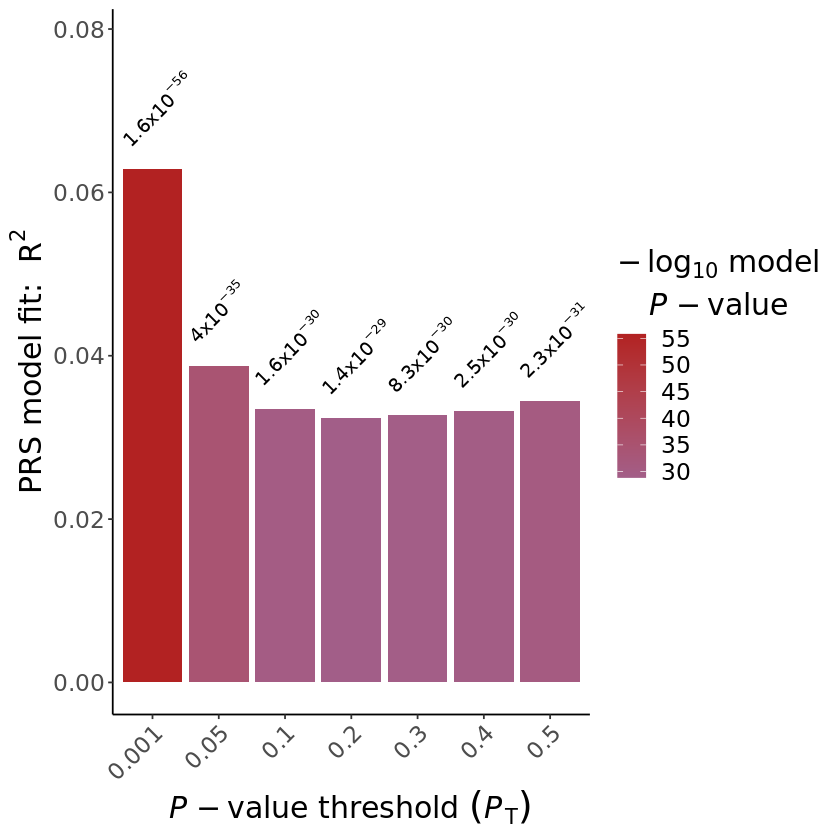

In [62]:
# Initialize ggplot, requiring the threshold as the x-axis (use factor so that it is uniformly distributed)
ggplot(data = prs.result, aes(x = factor(Threshold), y = R2)) +
    # Specify that we want to print p-value on top of the bars
    geom_text(
        aes(label = paste(print.p)),
        vjust = -1.5,
        hjust = 0,
        angle = 45,
        cex = 4,
        parse = T
    )  +
    scale_y_continuous(limits = c(0, max(prs.result$R2) * 1.25)) +
# Specify the axis labels
    xlab(expression(italic(P) - value ~ threshold ~ (italic(P)[T]))) +
    ylab(expression(paste("PRS model fit:  ", R ^ 2))) +
    # Draw a bar plot
    geom_bar(aes(fill = -log10(P)), stat = "identity") +
    # Specify the colors
    scale_fill_gradient2(
        low = "dodgerblue",
        high = "firebrick",
        mid = "dodgerblue",
        midpoint = 1e-4,
        name = bquote(atop(-log[10] ~ model, italic(P) - value),)
    ) +
  # Some beautification of the plot
    theme_classic() + theme(
        axis.title = element_text(face = "bold", size = 18),
        axis.text = element_text(size = 14),
        legend.title = element_text(face = "bold", size =
                                        18),
        legend.text = element_text(size = 14),
        axis.text.x = element_text(angle = 45, hjust =
                                    1)
    )

In [63]:
ggsave("EUR.height.bar.png", height = 7, width = 7)